##### Import modules:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
from pylab import rcParams

import time

rcParams['figure.figsize'] = 14,6

plt.style.use('ggplot')


%matplotlib inline

##### Loading data:

In [2]:
df = pd.read_csv('BaynesSoundMooring_5mbss_ConductivityTemperatureDepth_20200117T030000Z_20200119T235959Z-NaN.csv',skipinitialspace=True)
df.rename(columns={df.columns[0]: 'UTC time', df.columns[1]: 'Conductivity',df.columns[15]: 'Temperature'},inplace=True)
X = df[['Conductivity','Temperature']].values

##### Visualisation:

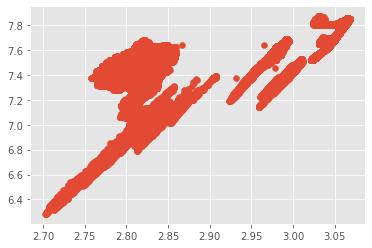

In [3]:
plt.scatter(df['Conductivity'],df['Temperature'])

###### Basic Stats:

In [4]:
N = X.shape[0]
mean = (1 / N) * np.sum(X, axis=0)
x_ = X - mean # Broadcast
var = (1 / N) * (np.dot(x_.T, x_))
print("Mean : {}".format(mean))
print("Mean with Numpy : {}".format(np.mean(X, axis=0)))

print("Variance : {}".format(var))
print("Variance with Numpy : {}".format(np.cov(X.T)))

Mean : [2.93211171 7.47042625]
Mean with Numpy : [2.93211171 7.47042625]
Variance : [[0.01101829 0.0247726 ]
 [0.0247726  0.08967184]]
Variance with Numpy : [[0.01101834 0.0247727 ]
 [0.0247727  0.08967221]]


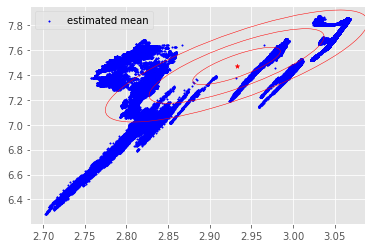

In [5]:
from matplotlib.patches import Ellipse


fig, ax = plt.subplots()

eig_values, eig_vectors = np.linalg.eig(var)

for i in range(1, 4):
    ellipse = Ellipse(xy=(mean[0], mean[1]), width=np.sqrt(eig_values[0]) * i,
                  height=np.sqrt(eig_values[1]) * i,
                  angle=np.rad2deg(np.arctan2(eig_vectors[1, 0], eig_vectors[0, 0])),
                 facecolor='none', edgecolor='red')
    ax.add_artist(ellipse)
# plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], color='blue', s=2)
plt.scatter(mean[0], mean[1], marker='*', color='red', s=20)
plt.legend(['estimated mean'])



##### K-Means Clustering 

Text(0, 0.5, 'Inertia')

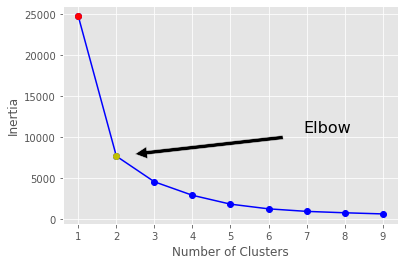

In [6]:
from sklearn.cluster import KMeans
inertias = []

for cluster_number in range(1,10):
  kmeans = KMeans(n_clusters=cluster_number, random_state=42).fit(X)
  inertias.append(kmeans.inertia_)  

#plot Inertia
plt.plot(range(1,10), inertias, 'bo-')
plt.annotate('Elbow',xy=(2, inertias[1]),
             xytext=(0.75, 0.50),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
)
plt.plot(1, inertias[0], 'ro-')
plt.plot(2, inertias[1], 'yo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

In [7]:
kmeans = KMeans(n_clusters = 2, init = "k-means++", random_state = 42)
s = time.time()

y_kmeans = kmeans.fit_predict(X)

e = time.time()
print("Training time = {}".format(e - s))

Training time = 1.46199631690979


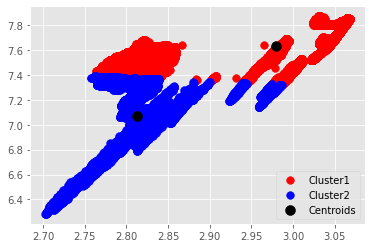

In [8]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
#plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 60, c = 'green', label = 'Cluster3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
plt.legend() 

plt.show()


In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture
n_clusters = 2
gmm_model = GaussianMixture(n_components=n_clusters)

s1 = time.time()

y_gm = gmm_model.fit_predict(X)

e1 = time.time()
print("Training time = {}".format(e1 - s1))

Training time = 2.286956548690796


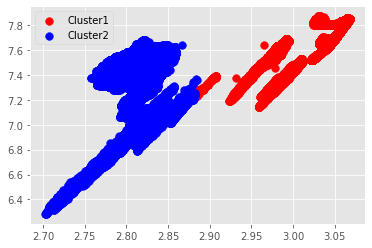

In [10]:
plt.scatter(X[y_gm == 0, 0], X[y_gm == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(X[y_gm == 1, 0], X[y_gm == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.legend() 

plt.show()


In [11]:
from sklearn.cluster import MiniBatchKMeans

from joblib import cpu_count


In [12]:
mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters= 2,
    batch_size=256 * cpu_count(),
    n_init=2,
    max_no_improvement=2,
    verbose=0,
    random_state=0,
)
t0 = time.time()
y_mb = mbk.fit_predict(X)
t_mini_batch = time.time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)


Time taken to run MiniBatchKMeans 0.58 seconds


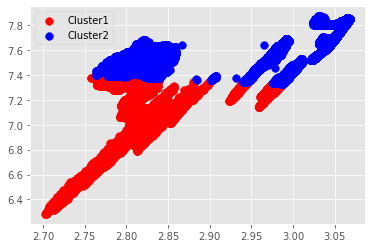

In [13]:
plt.scatter(X[y_mb == 0, 0], X[y_mb == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(X[y_mb == 1, 0], X[y_mb == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.legend() 

plt.show()


In [14]:
from sklearn.cluster import MiniBatchKMeans
from timeit import timeit
run_time_full = []
run_time_mini=[]
run_time_elkan = []
max_k = 10
for k in range(1, max_k):
    kmeans_ = KMeans(n_clusters=k, random_state=42,algorithm='full')
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    elkan_kmeans = KMeans(n_clusters=k, random_state=42 ,algorithm='elkan')
    run_time_full.append(timeit("kmeans_.fit(X)", number=10, globals=globals()))
    run_time_mini.append(timeit("minibatch_kmeans.fit(X)", number=10, globals=globals()))
    run_time_elkan.append(timeit("elkan_kmeans.fit(X)", number=10, globals=globals()))

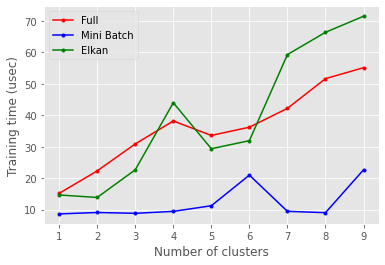

In [15]:
plt.clf()
plt.plot(range(1,max_k),run_time_full, 'r.-' , label='Full' )
plt.plot(range(1,max_k),run_time_mini, 'b.-' , label = 'Mini Batch' )
plt.plot(range(1,max_k),run_time_elkan, 'g.-', label = 'Elkan' )
plt.xlabel('Number of clusters')
plt.ylabel('Training time (usec)')
plt.legend(loc='upper left')
plt.show()

In [16]:
elkan_kmeans = KMeans(n_clusters=2, random_state=42 ,algorithm='elkan')
y_el =elkan_kmeans.fit_predict(X)

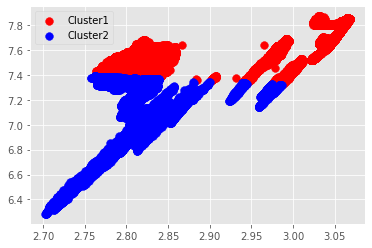

In [17]:
plt.scatter(X[y_el == 0, 0], X[y_el == 0, 1], s = 60, c = 'red', label = 'Cluster1')
plt.scatter(X[y_el == 1, 0], X[y_el == 1, 1], s = 60, c = 'blue', label = 'Cluster2')
plt.legend() 

plt.show()


In [18]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(X) # fitting the data to the object
distances,indices=nbrs.kneighbors(X) # finding the nearest neighbours

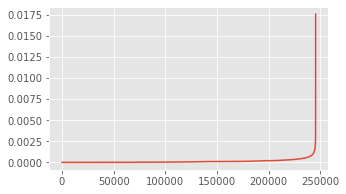

In [19]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

In [20]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps = 0.0001, min_samples = 57).fit(X) # fitting the model


labels = db.labels_
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 245277


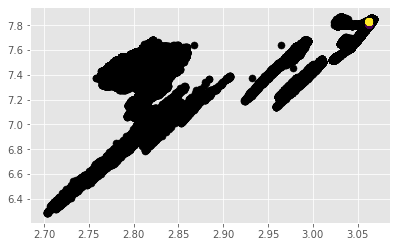

In [21]:
# Separate outliers from clustered data
outliers_X = X[labels == -1]
clusters_X = X[labels != -1]

colors_clusters = labels[labels != -1]
colors_outliers = 'black'

# plot clusters and outliers
fig = plt.figure()
ax = fig.add_axes([.1, .1, 1, 1])

ax.scatter(outliers_X[:,0],outliers_X[:,1], c = colors_outliers,s =50)
ax.scatter(clusters_X[:,0],clusters_X[:,1], c = colors_clusters,s =50)

In [26]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=150, min_samples=20).fit(X)
labels = clusterer.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 192
Estimated number of noise points: 46321


In [27]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1150).fit(X)
labels = clusterer.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)   

Estimated number of clusters: 13
Estimated number of noise points: 21624


#### Exploratory anomalies detection analysis


In [38]:
con = X[:,0]
tem = X[:,1]

dataset = pd.DataFrame()
dataset['Conductivity'] = con.tolist()
dataset['Temperature'] = tem.tolist()

dataset.head(3)

,Conductivity,Temperature
0,2.97789,7.3472
1,2.97792,7.3472
2,2.97787,7.3470


In [50]:
from sklearn.decomposition import PCA
n_components = 2
whiten = False
random_state = 2018
pca = PCA(n_components=n_components, whiten=whiten, \
random_state=random_state)
X_train_PCA = pca.fit_transform(X)
X_train_PCA = pd.DataFrame(data=X_train_PCA)